In [1]:
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

is_cuda = torch.cuda.is_available()
device = 'cuda' if is_cuda else 'cpu'
if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")
    
torch.set_printoptions(precision=3, sci_mode=False)
np.set_printoptions(suppress=True)

In [2]:
from lib.Signature import Signature, Basepoint, sig_lreg, Cumsum2
from lib.Baseline import ConditionalGenerator
from lib.Utilities import plot_baseline as plot, get_n_params
from lib.Training_sigwgan import train_sigwgan

In [3]:
data = torch.load('../data/data.pt')

Let's first compute the truncated signatures, and then we will approximate the linear functional that predicts the expected signature

In [4]:
sig_X = Signature(depth=5, augmentations = [Basepoint, Cumsum2], 
                  data_size=data['X_train'].shape[2],
                  interval=[0, data['X_train'].shape[1]+1], 
                  q=1, 
                  t_norm = data['X_train'][:, :, 0].max()).to(device)

sig_Y = Signature(depth=4, augmentations = [Cumsum2], 
                  data_size=data['Y_train'].shape[2],
                  interval=[0, data['Y_train'].shape[1]+1], 
                  q=1, 
                  t_norm = data['Y_train'][:, :, 0].max()).to(device)

In [5]:
signatures_X, signatures_Y, signatures_Y_pred, sig_Y = sig_lreg(sig_X, sig_Y, data, 528, alpha=0.1, normalize_sig = True)

MSE train: 0.5384 MSE val: 0.4863 MSE test: 0.5877


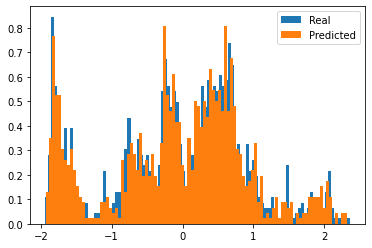

In [6]:
plt.rcParams['figure.figsize'] = [6, 4]
i = 0
a = plt.hist(signatures_Y['val'][:, i].numpy(), density = True, bins = 100, label = 'Real')
b = plt.hist(signatures_Y_pred['val'][:, i].numpy(), density = True, bins = 100, label='Predicted')
plt.legend()

We will scale the parameters of the generator to have the right size. This is done by trial and error, and will help training.

Total number of parameters:     101953


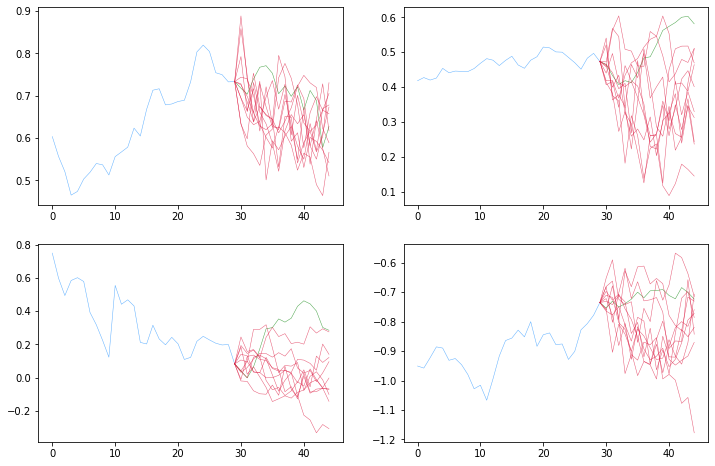

In [7]:
G = ConditionalGenerator(input_size = 1, output_size = 1, hidden_size = 64, num_layers = 2, noise_size = 5, 
                         translation = True).to('cuda')

print(f"Total number of parameters: {get_n_params(G):10}")

init_mult1 = 1
init_mult2 = 10
init_mult3 = 0.4
with torch.no_grad():
    for param in G.encoder.parameters():
        param *= init_mult1
        
    for param in G.cgenerator.parameters():
        param *= init_mult2
        
    for param in G.out.parameters():
        param *= init_mult3
        
plot(G=G, X_data=data['X_train'], Y_data=data['Y_train'], nsamples_fs=10, device='cuda')

## Training

In [8]:
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3)

hp = {'steps_per_print': 250, 'nsamples_fs': 100, 'steps':10,
      'batch_size': 528}

In [9]:
train_dataset = TensorDataset(data['X_train'][:, :, 1:], signatures_Y_pred['train'])
train_dataloader = DataLoader(train_dataset, hp['batch_size'], shuffle=True)

val_dataset = TensorDataset(data['X_val'][:, :, 1:], signatures_Y_pred['val'])
val_dataloader = DataLoader(val_dataset, hp['batch_size'], shuffle=True)

test_dataset = TensorDataset(data['X_test'][:, :, 1:], signatures_Y_pred['test'])
test_dataloader = DataLoader(test_dataset, hp['batch_size'], shuffle=True)

In [10]:
channels_sig_Y = signatures_Y_pred['train'].shape[1]
print(f"The number of elements of the signature Y is {channels_sig_Y}")

The number of elements of the signature Y is 120


  0%|          | 0/10 [00:00<?, ?it/s]

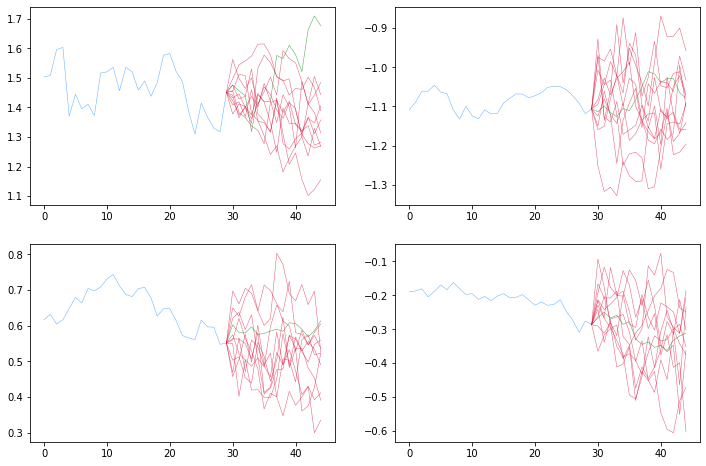

 10%|█         | 1/10 [00:02<00:22,  2.49s/it]

Step:    0 Val loss (unaveraged): 4.1663 Train_loss (unaveraged): 4.1613


 80%|████████  | 8/10 [00:05<00:00,  2.20it/s]

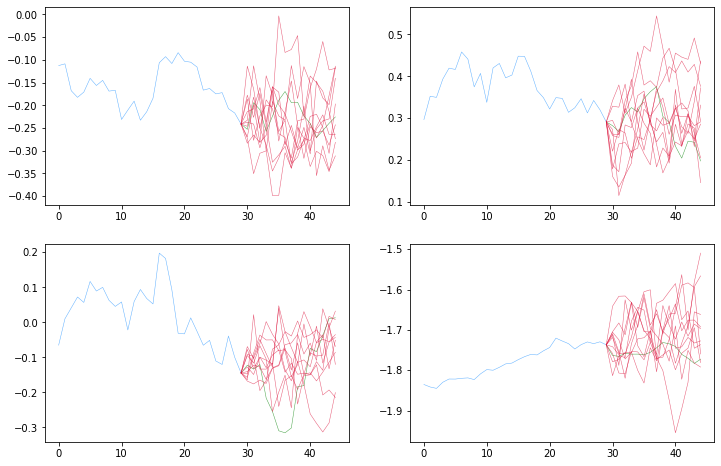

100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Step:    9 Val loss (unaveraged): 3.2536 Train_loss (unaveraged): 3.2254
Best validation loss: 3.2536 Test loss: 2.9828
Total time (in hours): 0.0026 Number of steps:     9
Maximum memory allocated (in MB): 9201.5862 Total number of parameters:     101953


In [11]:
G, G_optimizer = train_sigwgan(G, sig_Y, train_dataloader, val_dataloader, test_dataloader, hp, data['X_train'], data['Y_train'], 
                  G_optimizer, patience = 1000, epsilon = 0, max_time = 2)

We load the pre-trained model.

In [12]:
save_model=False
if save_model:
    torch.save(G.state_dict(), 'G.pt')
    
load_model = True
if load_model:
    G.load_state_dict(torch.load('G.pt'))

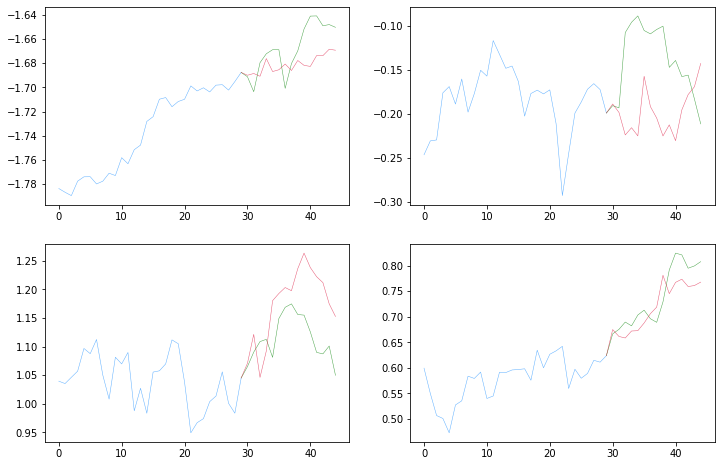

In [13]:
plot(G.to('cpu'), data['X_test'].cpu(), data['Y_test'].cpu(), nsamples_fs=1, device='cpu')

## Metrics

Next we evaluate the model according to the different metrics described in the memory.

### Classification error

First we train a classificator that tells real from fake data.

In [15]:
from lib.Metrics import evaluate_performance, Evaluator

In [16]:
E = Evaluator(input_size = [1,1], hidden_size = [5,5], num_layers = [4,4], sep=data['X_train'].shape[1]).to(device)
data_e = data.copy()
for dataset in data_e:
    data_e[dataset] = data_e[dataset][:, :, 1:]

E_optimizer = torch.optim.Adam(E.parameters(), lr=1e-3)

hp_e = {'batch_size': 528, 'steps': 10000, 'steps_per_print': 500, 'E_optimizer': E_optimizer}

E = evaluate_performance(E, G, data_e, hp_e, device='cuda', generator = 'lstm', print_=False)

Training samples:  10302  Validation samples:  2208  Test samples:  2208


100%|██████████| 10000/10000 [03:07<00:00, 53.25it/s]

AUC: 0.6127 Accuracy: 0.5643


### Extreme values metric

Next we evaluate the Extreme Values metric. The names of the function is trading_metric, with the option of specifying whether you want to predict the probability of going up (type_='buying') or down (type_'selling'), and the threshold you want to set (alpha).

In [17]:
from lib.Metrics import trading_metric, summary_statistics, precision_c

In [18]:
stats_data = torch.load('../data/stats_data.pt')

In [19]:
test_pred_buying, test_real_buying = trading_metric(data['X_test'], data['Y_test'], G, 1000, 10, alpha=0.1, pct = True, 
                                                    type_='buying', generator = 'lstm', sig_X = None, device='cuda',
                                                   stats = stats_data)

test_pred_selling, test_real_selling = trading_metric(data['X_test'], data['Y_test'], G, 1000, 10, alpha=-0.1, pct = True, 
                                                      type_='selling', generator = 'lstm', sig_X = None, device='cuda',
                                                     stats = stats_data)

In [20]:
summary_statistics(test_pred_buying, test_real_buying)

The ROC AUC score is 0.7952


In [21]:
summary_statistics(test_pred_selling, test_real_selling)

The ROC AUC score is 0.7835


### Unconditional Wasserstein-1 distance


In [22]:
from lib.Metrics import distribution_metric

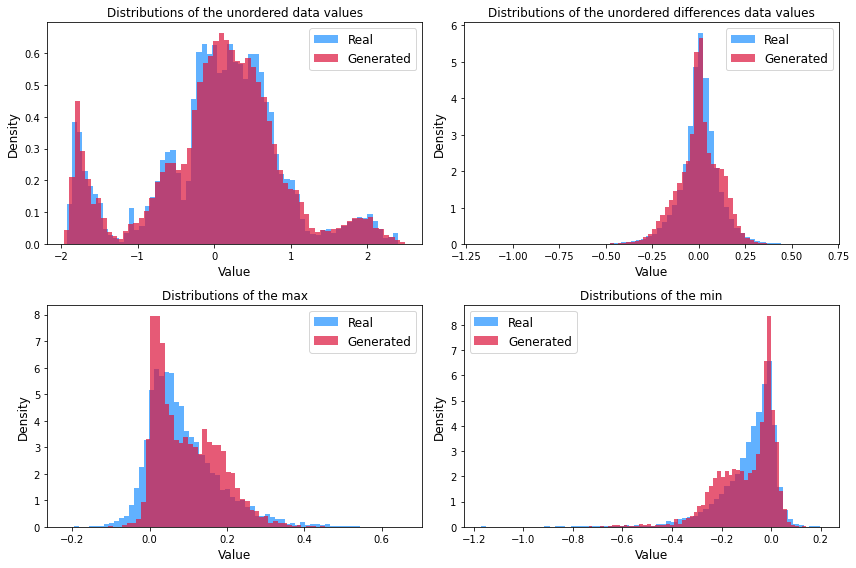

The Wasserstein-1 distance between the real and generated distributions is 0.0121
The Wasserstein-1 distance between the real and generated difference distributions is 0.0127
The Wasserstein-1 distance between the real and generated max distributions is 0.0154
The Wasserstein-1 distance between the real and generated min distributions is 0.0155


In [23]:
distribution_metric(data['X_test'][:, :, 1:].to(device), data['Y_test'][:, :, 1:].to(device), G.to(device), sig_X = None, 
                    generator='lstm', log=False, inc = False, stats=None)

### Signature-Wasserstein-1 metric

In [24]:
from lib.Metrics import signature_metric

In [25]:
signature_metric(data, G, 6, 5, 100, 100, 'lstm', normalize=True, device='cuda')

MSE train: 0.7885 MSE val: 0.8100 MSE test: 1.3886
The signature-wasserstein metric loss is 4.4482
